# Genetic Programming

Genetically evolving programs to classify species from the [Iris dataset](https://www.kaggle.com/datasets/uciml/iris).

In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

from parse_tree import TerminalGenerationRules
from genetic_programming import IrisGP
from visualizations import Visualizations
from parameter_sweep import ParameterSweep

## Import Dataset

Split into training and test sets.

In [120]:
iris = pd.read_csv("../data/Iris.csv")
train_df, test_df = train_test_split(iris, test_size=0.2, random_state=3)

## Run the Genetic Programming Evolution

Producing a `best` program to classify irises.

In [121]:
random.seed(2)

FUNCTION_SET = ["+", "-", "*", "/"]
TERMINAL_RULES = TerminalGenerationRules(
    ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"],
    (-10, 10),
    ints_only=False,
    no_random_constants=False,
)
MAX_DEPTH = 3
TERMINAL_PROBABILITY = 0.2
g = IrisGP(
    FUNCTION_SET,
    TERMINAL_RULES,
    MAX_DEPTH,
    TERMINAL_PROBABILITY,
)

POPULATION_SIZE = 50
GENERATIONS = 20
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.9
CHAMPION_SURVIVAL_PERCENTAGE = 0.1
best, fitness, history = g.solve(
    POPULATION_SIZE,
    GENERATIONS,
    CROSSOVER_RATE,
    MUTATION_RATE,
    CHAMPION_SURVIVAL_PERCENTAGE,
    train_df,
)

## Evaluate the Best Program

Print the best program in tree structure.

In [122]:
print(best.pretty_print())

└── *
    ├── *
    │   ├── /
    │   │   ├── +
    │   │   │   ├── +
    │   │   │   │   ├── +
    │   │   │   │   │   ├── -
    │   │   │   │   │   │   ├── PetalLengthCm
    │   │   │   │   │   │   └── SepalWidthCm
    │   │   │   │   │   └── PetalLengthCm
    │   │   │   │   └── PetalWidthCm
    │   │   │   └── +
    │   │   │       ├── SepalLengthCm
    │   │   │       └── +
    │   │   │           ├── SepalLengthCm
    │   │   │           └── PetalWidthCm
    │   │   └── *
    │   │       ├── *
    │   │       │   ├── +
    │   │       │   │   ├── PetalWidthCm
    │   │       │   │   └── PetalWidthCm
    │   │       │   └── SepalWidthCm
    │   │       └── 8.7142
    │   └── PetalWidthCm
    └── PetalWidthCm



With sklearn's classification report, we can get various metrics on the performance of this program.

In [123]:
vis = Visualizations(best, test_df)
vis.print_classification_report()

Accuracy: 0.9333333333333333

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.80      0.89        10
 Iris-virginica       0.83      1.00      0.91        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



Out of the 30 irises in the test set, the best program only incorrectly classified two of them. These two were both **versicolors** that were incorrectly classified as **viriginicas**.

In [124]:
vis.test_results[vis.test_results["Correct"] == False]

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Correct,PredictedValue,PredictedSpecies
72,73,6.3,2.5,4.9,1.5,Iris-versicolor,False,0.788368,Iris-virginica
76,77,6.8,2.8,4.8,1.4,Iris-versicolor,False,0.66558,Iris-virginica


All irises are plotted by the dimensions of various parts of the flower. In the first graph, they are plotted based on the length and width of the petal. In the second graph, they are plotted based on the length and width of the sepal. Points are colored based on the species that the best program predicted them to be. The correct predictions are smaller and transparent, while the incorrect predictions are larger and opaque.

When looking at petal dimension, we can see that the two **versicolors** that were incorrectly classified as **virginicas** are towards the cluster of other **virginicas**. Furthermore, when looking at sepal dimension, we can see that the two misclassified **versicolors** are actually within the cluster of **virginicas**.

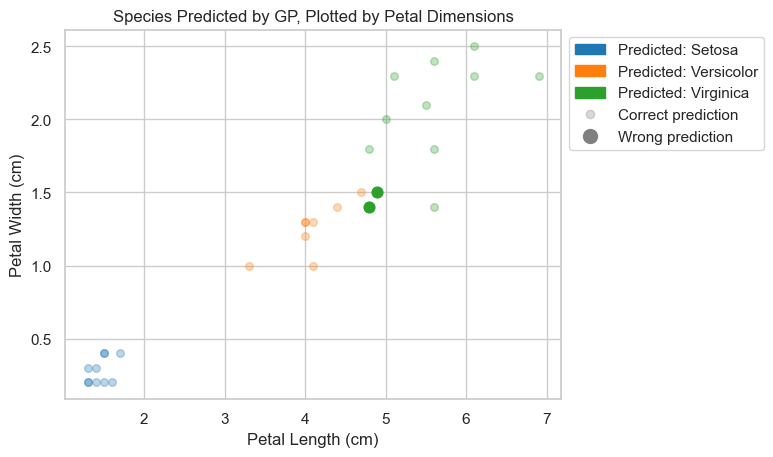

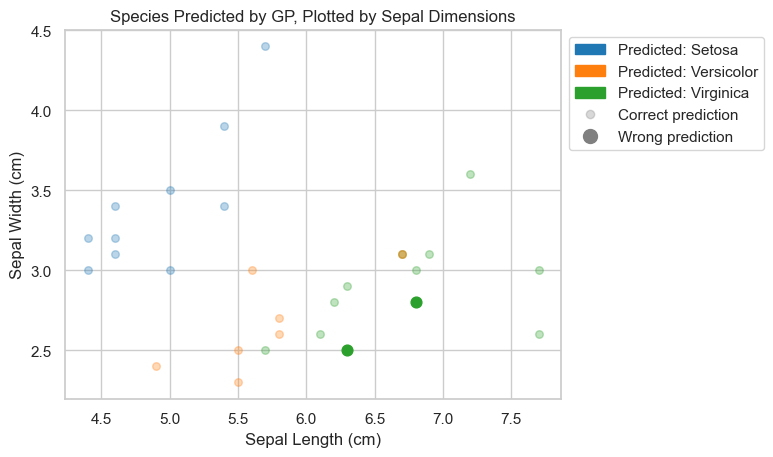

In [125]:
vis.plot_predictions_by_dimension("Petal")
vis.plot_predictions_by_dimension("Sepal")

Looking at the confusion matrix, we can see again that the program properly classified all **setosas** and **virginicas**, but misclassified two **versicolors** as **virginicas**. This error in classifying **versicolors** makes sense, as they were the "middle" category of the classification. The GP programs output a number, and only if that number is between the low and high thresholds is it then classified as **versicolor**. Any value below under the low threshold is classified as **setosa**, and any value above the high threshold is classified as **virginica**. This setup makes it "harder" for virginicas to be classified as they have both an upper and lower bound.

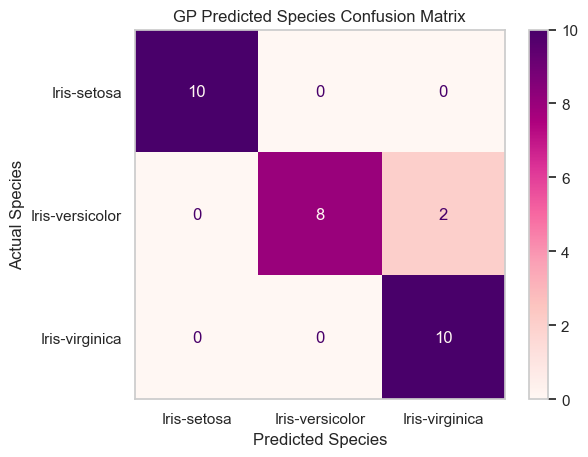

In [126]:
vis.plot_confusion_matrix()

## Parameter Sweep

Sweep through various parameters of the genetic programming algorithm, and see how that impacts the accuracy of the best program. For each set of unique parameters, the program was run 10 times, and the average accuracy was taken. Default values were chosen for parameters that were not being swept, based on standards of literature and former trial and error when developing the algorithm, trying to balance runtime and accuracy. The default values are:
- `function_set`: ["+", "-", "*", "/"]
- `terminal_rules`:
    - `literals`: ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
    - `constants_range`: (-10, 10)
    - `ints_only`: False
    - `no_random_constants`: False
- `max_depth`: 3
- `terminal_probability`: 0.2
- `population_size`: 50
- `generations`: 20
- `crossover_rate`: 0.9
- `mutation_rate`: 0.1
- `champion_survival_percentage`: 0.1

The values that were swept are:
- `population_size`: 20, 40, 60, 80, 100
- `generations`: 10, 30, 50, 70
- `crossover_rate`: 0.6, 0.7, 0.8, 0.9, 1.0
- `mutation_rate`:  0, 0.005, 0.01, 0.5, 0.1
- `champion_survival_percentage`: 0.1, 0.2, 0.3, 0.4, 0.5
- `max_depth`: 1, 2, 3, 4

`param_grid` is a dictionary representing the values above. The values are generated with `np.arange`, note that the `stop` argument (second argument) is exclusive, which is why the values are just greater than the max value we wish to sweep through. The comments to the right are the approximate time it took for each sweep to run, in [minutes]:[seconds].

These parameter sweeps take about 50 minutes to run, so the results are saved and loaded from `data/param_sweep/parameter_sweep.csv`. The code that was used to generate the results is commented out below.

In [134]:
param_grid = {
    "population_size": np.arange(20, 101, 20),
    "generations": np.arange(10, 71, 20),
    "crossover_rate": np.arange(0.6, 1.01, 0.1),
    "mutation_rate": [0, 0.005, 0.01, 0.05, 0.1],
    "champion_survival_percentage": np.arange(0, 0.51, 0.1),
    "max_depth": np.arange(1, 4.1, 1),
}

In [ ]:
# Takes about 50 minutes to run

# random.seed(2)
# for param_name, values in param_grid.items():
#     sweep_results_df = ParameterSweep.sweep_single_parameter(param_name, param_grid[param_name], train_df, test_df)
#     sweep_results_df.to_csv(f"../data/param_sweep/param_sweep_{param_name}.csv", index=False)

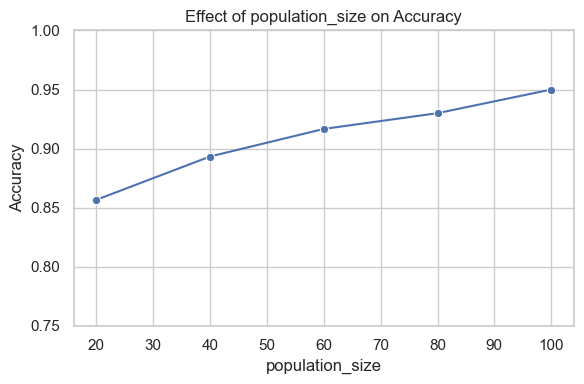

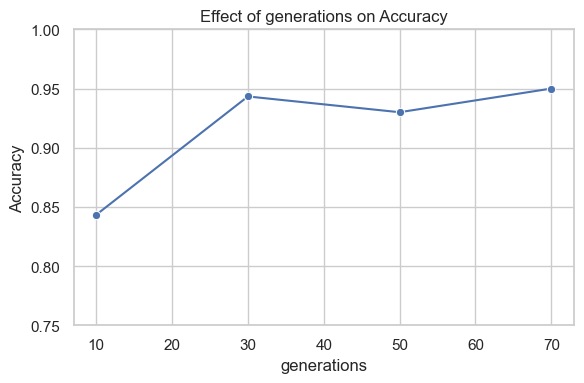

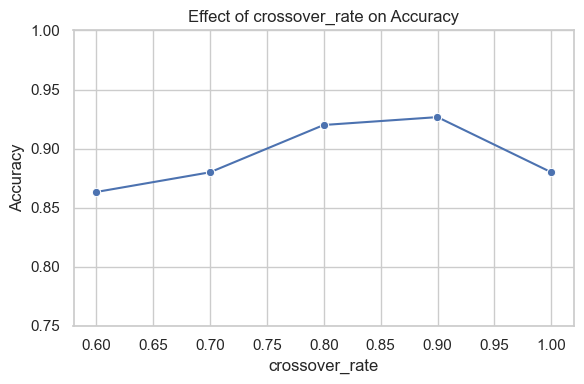

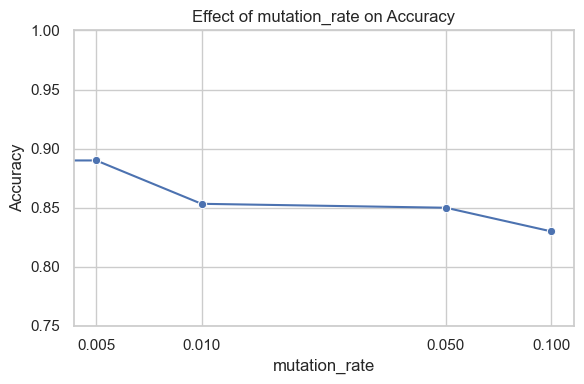

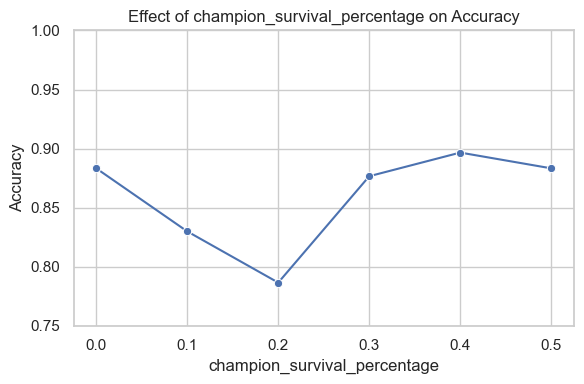

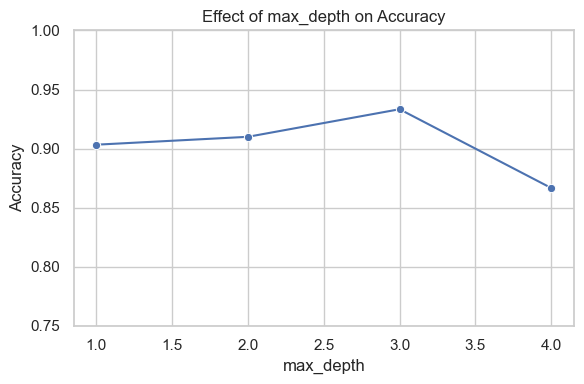

In [ ]:
sweep_results_df = ParameterSweep.load_from_csv("../data/param_sweep", param_grid)
ParameterSweep.plot_paramter_sweep_results(param_grid, sweep_results_df)